# Sort candidate pulse sequences

In [35]:
import sys
import os
import re
import pandas as pd

In [18]:
candidates = []
with open('../../data/2021-01/20210129-130800/candidates.txt') as file:
    for line in file:
        candidates.append(line)

In [7]:
test = candidates[0]

In [9]:
m = re.search(r'(.*?) candidate pulse sequence from \d \((.*?), array\((.*?)\), (.*?)\)\n', test)

In [11]:
m.groups()

('2021-01-29 15:09:41.236669',
 '[0, 0, 3, 1, 1, 3, 4, 3, 4, 4, 1, 4, 2, 4, 2, 2, 4, 2, 1, 1, 4, 2, 1, 2, 0, 1, 2, 3, 0, 3, 0, 3, 0, 1, 0, 2, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 4]',
 '[1., 0., 0., 0., 0.]',
 '2.671719175460031')

In [16]:
m.group(1)

'2021-01-29 15:09:41.236669'

In [29]:
c2 = []
for c in candidates:
    try:
        m = re.search(r'(.*?) candidate pulse sequence from \d+ \((.*?), array\((.*?)\), (.*?)\)\n', c)
        c2.append({
            'timestamp': m.group(1),
            'sequence': m.group(2),
            'last_pulse': m.group(3),
            'value': float(m.group(4))
        })
    except Exception as e:
        print(c)

2021-01-30 12:53:20.1423162021-01-30 12:53:20.143964 candidate pulse sequence from 9  updated network (iteration 30500) pulse_sequence_count: 49855



In [31]:
len(c2)

391

In [36]:
df = pd.DataFrame(c2)

array([[<AxesSubplot:title={'center':'value'}>]], dtype=object)

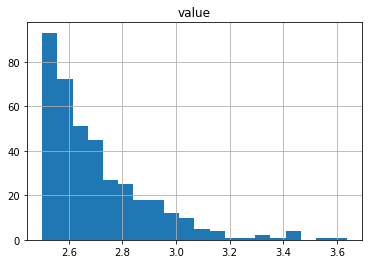

In [39]:
df.hist('value', bins=20)

In [41]:
df

,timestamp,sequence,last_pulse,value
0,2021-01-29 15:09:41.236669,"[0, 0, 3, 1, 1, 3, 4, 3, 4, 4, 1, 4, 2, 4, 2, ...","[1., 0., 0., 0., 0.]",2.671719
1,2021-01-29 15:12:08.380437,"[2, 4, 0, 0, 2, 1, 3, 2, 3, 2, 0, 1, 0, 1, 0, ...","[1., 0., 0., 0., 0.]",2.886061
2,2021-01-29 15:16:04.672823,"[2, 2, 3, 1, 1, 2, 1, 2, 0, 1, 1, 2, 4, 3, 2, ...","[1., 0., 0., 0., 0.]",2.505068
3,202101-29 15:23:45.227140,"[4, 4, 1, 4, 2, 2, 4, 2, 1, 2, 2, 3, 2, 0, 0, ...","[0., 0., 0., 1., 0.]",3.435580
4,2021-01-29 15:24:01.733737,"[3, 1, 0, 0, 3, 4, 4, 4, 3, 1, 3, 4, 4, 1, 0, ...","[0., 1., 0., 0., 0.]",2.774834
...,...,...,...,...
386,2021-01-30 14:55:39.078416,"[3, 3, 2, 2, 4, 1, 4, 3, 2, 1, 1, 1, 3, 1, 1, ...","[0., 0., 0., 1., 0.]",2.539467
387,2021-01-30 14:56:30.369013,"[4, 4, 0, 4, 0, 2, 2, 3, 1, 0, 1, 1, 4, 4, 1, ...","[1., 0., 0., 0., 0.]",2.834309
388,2021-01-30 15:00:14.288051,"[4, 2, 4, 2, 0, 3, 4, 1, 0, 1, 1, 1, 3, 2, 3, ...","[1., 0., 0., 0., 0.]",2.551818
389,2021-01-30 15:00:23.786325,"[1, 4, 1, 3, 3, 4, 4, 1, 3, 4, 1, 2, 3, 2, 3, ...","[1., 0., 0., 0., 0.]",2.593527
